In [1]:
import os
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections

from tqdm import tqdm
from functions import ANALYSIS
from architecture import ARCHITECTURE
import architecture

from collections import Counter
from IPython.display import Image

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical


import tensorflow.keras.backend as K
import keras

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

EXP = 'CD100T10'

obj = ANALYSIS(EXP)
arch_obj = ARCHITECTURE()

In [2]:
import tensorflow as tf
print(tf.__version__)
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

2.2.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [3]:
P = pd.read_csv('data/ProtSeqForModel.csv')
D = pd.read_csv('data/DrugSeqForModel.csv')
des_drug = np.load('data/DrugDesForModel.npy')

drug_smiles=pd.read_csv('data/drug_smiles.csv')[['drug','smile','seq_char_count']]
DTI_index=pd.read_csv('data/DTI_index.csv')[['target','drug','IC50','unit','activity','target_uniprot']]

# Encode amino acides and smile characters
codes_target = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
         'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
char_dict_target = obj.create_dict(codes_target)

codes_drug = [char for char in ''.join(set(''.join(drug_smiles['smile'].values)))]
char_dict_drug = obj.create_dict(codes_drug)

encode_target = obj.integer_encoding(P, char_dict_target) 
encode_drug = obj.integer_encoding(D, char_dict_drug) 

# padding sequences
max_length_target = 1000
max_length_drug = 150
pad_target = pad_sequences(encode_target, maxlen=max_length_target, padding='post', truncating='post')
pad_drug = pad_sequences(encode_drug, maxlen=max_length_drug, padding='post', truncating='post')

# label/integer encoding output variable: (y)
le = LabelEncoder()
y = le.fit_transform(DTI_index['activity'].tolist())
# One hot encoding of outputs
y = to_categorical(y)

In [4]:
# Define architecture
def get_model():
    input_target, att_out_target = arch_obj.protSeq(max_length_target)
    input_drug, att_out_drug = arch_obj.drugSeq(max_length_drug)
    #input_drug_des, dense_drug_des_2 = arch_obj.drugDes(111)

    concat = Concatenate()([att_out_target,att_out_drug])

    dense_1 = Dense(512, activation = 'relu',kernel_initializer='glorot_normal')(concat)
    #dense_1_dropout = Dropout(0.1)(dense_1)
    dense_2 = Dense(512, activation = 'relu',kernel_initializer='glorot_normal')(dense_1)
    #dense_3 = Dense(512, activation = 'relu',kernel_initializer='glorot_normal')(dense_2)
    dense_2_dropout = Dropout(0.2)(dense_2)

    x_output = Dense(3, activation='softmax')(dense_2_dropout)

    # Bulid and compile model
    model = Model(inputs=[input_target, input_drug], outputs=x_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    #model1.summary()
    return model

In [5]:
# Initialize results dicts
CV = [0,1,2,3,4]
results_CV = {key: None for key in CV}

# Training
CV = 5
for i in range(CV):
    # device = cuda.get_current_device()
    # device.reset()

    # Split indics into train/test
    from sklearn.model_selection import train_test_split
    indices = list(range(len(DTI_index)))
    train_target, test_target, train_drug, test_drug, y_train, y_test = train_test_split(pad_target, pad_drug, y, test_size=0.2, random_state=i)

    # Early Stopping & checkpoint
    model = get_model()
    es = EarlyStopping(monitor='val_loss', patience=40, verbose=1)
    filepath='checkpoints/'+EXP+'/'+EXP+'_cp_'+str(i)+'.hdf5'
    model_checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
    reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=10, verbose=1, epsilon=1e-4, mode='min')

    history = model.fit(
        [train_target, train_drug], y_train,
        epochs=500, batch_size=256,
        validation_split=0.2,
        callbacks=[es, model_checkpoint]
        )

    # Load saved model
    saved_model = load_model('checkpoints/'+EXP+'/'+EXP+'_cp_'+str(i)+'.hdf5',custom_objects={'attention': architecture.attention()})

    # Evaluate the model on the test data using `evaluate`
    print("Evaluate on test data")
    res = saved_model.evaluate([test_target, test_drug], y_test, batch_size=256)
    print("test loss, test acc:", res)

    # Calculate ROC and PR characteristics
    roc_auc, fpr, tpr = obj.roc(saved_model, y_test, a = test_target, b = test_drug)
    precision, recall, average_precision = obj.aupr(saved_model, y_test, a = test_target, b = test_drug)
    prediction = saved_model.predict([test_target,test_drug])
    f1 = f1_score(np.argmax(y_test,axis=1), np.argmax(prediction,axis=1), average='macro')

    keys = ['val_loss','val_accuracy','roc_auc','fpr','tpr','f1_score', 'precision','recall','average_precision']
    results = {key: None for key in keys}

    results['val_loss'] = res[0]
    results['val_accuracy'] = res[1]
    results['roc_auc'] = roc_auc
    results['fpr'] = fpr
    results['tpr'] = tpr
    results['f1_score'] = f1
    results['precision'] = precision
    results['recall'] = recall
    results['average_precision'] = average_precision
    results_CV[i] = results
    
    del model
    del saved_model

===========>.] - ETA: 0s - loss: 0.5583 - accuracy: 0.7802
Epoch 00131: val_loss improved from 0.68170 to 0.66828, saving model to checkpoints/CD100T10/CD100T10_cp_4.hdf5
155/155 [==============================] - 19s 122ms/step - loss: 0.5581 - accuracy: 0.7803 - val_loss: 0.6683 - val_accuracy: 0.7418
Epoch 132/500
155/155 [==============================] - ETA: 0s - loss: 0.5437 - accuracy: 0.7872
Epoch 00132: val_loss did not improve from 0.66828
155/155 [==============================] - 19s 120ms/step - loss: 0.5437 - accuracy: 0.7872 - val_loss: 0.6785 - val_accuracy: 0.7376
Epoch 133/500
155/155 [==============================] - ETA: 0s - loss: 0.5427 - accuracy: 0.7870
Epoch 00133: val_loss did not improve from 0.66828
155/155 [==============================] - 19s 121ms/step - loss: 0.5427 - accuracy: 0.7870 - val_loss: 0.7083 - val_accuracy: 0.7291
Epoch 134/500
155/155 [==============================] - ETA: 0s - loss: 0.5437 - accuracy: 0.7876
Epoch 00134: val_loss did no

In [7]:
import pickle
def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [8]:
save_obj(results_CV, EXP)

In [19]:
# EXTERNAL VALIDATION
davis_metz_DTI = pd.read_csv('val_data/davis_metz_DTI.csv')
davis_metz_targets = os.listdir('val_data/fasta_davis_metz')  # List all target fasta files
davis_metz_drug_smiles = pd.read_csv('val_data/davis_metz_smiles.csv')
davis_metz_drug_des = pd.read_csv('val_data/fset_drugs_davis_metz.csv')
davis_metz_drug_des = davis_metz_drug_des.loc[:, davis_metz_drug_des.columns != 'Unnamed: 0']

# Fetch fasta sequences form files and create target index dataframe
def fetchFasta(targets):
    target_seq = pd.DataFrame(columns=['target','seq'])
    for fasta in tqdm(targets):
        f = open('val_data/fasta_davis_metz/'+fasta,'r')
        lines = "".join(line.strip() for line in f.readlines()[1:])
        dict = {'target':fasta.split('.')[0], 'seq':lines}
    
        target_seq = target_seq.append(dict, True)
        f.close()
    return target_seq

davis_metz_target_seq = fetchFasta(davis_metz_targets)

100%|██████████| 154/154 [00:00<00:00, 782.80it/s]


In [20]:
eval_P = pd.DataFrame()
for target in davis_metz_DTI['protein_id']:
    dic = davis_metz_target_seq[davis_metz_target_seq['target']==target]
    eval_P = eval_P.append(dic)

eval_T = pd.DataFrame()
for drug in davis_metz_DTI['compound_id']:
    dic = davis_metz_drug_smiles[davis_metz_drug_smiles['drug']==drug][['drug', 'seq']]
    eval_T = eval_T.append(dic)

eval_D = pd.DataFrame()
for drug in davis_metz_DTI['compound_id']:
    des = davis_metz_drug_des[davis_metz_drug_des['Drug']==drug]
    dic = des.loc[:,des.columns!='Drug']
    eval_D = eval_D.append(dic)

# label/integer encoding output variable: (y)
davis_metz_le = LabelEncoder()
davis_metz_y = davis_metz_le.fit_transform(davis_metz_DTI['activity'].tolist())
# One hot encoding of outputs
davis_metz_y = to_categorical(davis_metz_y)

In [21]:
davis_metz_codes_drug = [char for char in ''.join(set(''.join(davis_metz_drug_smiles['seq'].values)))]
davis_metz_char_dict_drug = obj.create_dict(davis_metz_codes_drug)

davis_metz_encode_target = obj.integer_encoding(eval_P, char_dict_target) 
davis_metz_encode_drug = obj.integer_encoding(eval_T, davis_metz_char_dict_drug) 

# padding sequences
max_length_target = 1000
max_length_drug = 150
davis_metz_pad_target = pad_sequences(davis_metz_encode_target, maxlen=max_length_target, padding='post', truncating='post')
davis_metz_pad_drug = pad_sequences(davis_metz_encode_drug, maxlen=max_length_drug, padding='post', truncating='post')

davis_metz_pad_target.shape, davis_metz_pad_drug.shape, eval_D.shape, davis_metz_y.shape

((2575, 1000), (2575, 150), (2575, 111), (2575, 3))

In [29]:
# Load saved model
saved_model = load_model('checkpoints/'+EXP+'/'+EXP+'_cp_2.hdf5', custom_objects={'attention': architecture.attention()})
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = saved_model.evaluate([davis_metz_pad_target, davis_metz_pad_drug], davis_metz_y, batch_size=256)
print("test loss, test acc:", results)

from sklearn.metrics import classification_report
import numpy as np
prediction = saved_model.predict([davis_metz_pad_target, davis_metz_pad_drug, eval_D.values])
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(np.argmax(davis_metz_y,axis=1), np.argmax(prediction,axis=1), target_names=target_names))

Evaluate on test data
11/11 [==============================] - 0s 45ms/step - loss: 3.2183 - accuracy: 0.5340
test loss, test acc: [3.2183120250701904, 0.5339806079864502]
              precision    recall  f1-score   support

     class 0       0.00      0.00      0.00       210
     class 1       0.68      0.69      0.68      1808
     class 2       0.18      0.24      0.21       557

    accuracy                           0.53      2575
   macro avg       0.29      0.31      0.30      2575
weighted avg       0.51      0.53      0.52      2575



In [50]:
# Load saved model
saved_model = tf.keras.models.load_model('checkpoints/'+EXP+'/'+EXP+'_cp.hdf5', custom_objects={'attention': architecture.attention()})

# Calculate ROC and PR characteristics
roc_auc, fpr, tpr = obj.roc(saved_model, y_test, a = test_target, b = test_drug)
precision, recall, average_precision = obj.aupr(saved_model, y_test, a = test_target, b = test_drug)

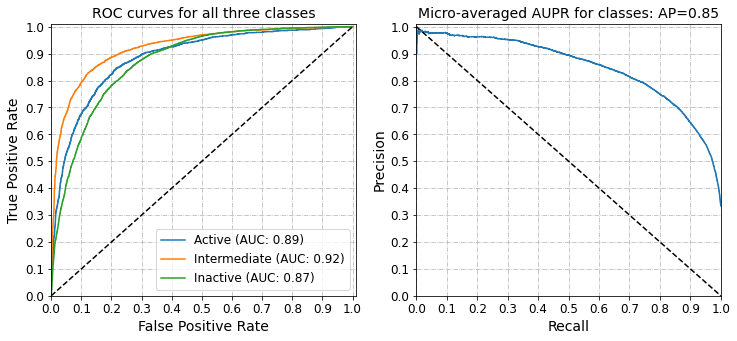

In [10]:
# Plot ROC/PR curve
obj.plotROC_PR(fpr, tpr, roc_auc, precision, recall, average_precision, validation=False, save=False)

In [35]:
from sklearn.metrics import f1_score
prediction = saved_model.predict([test_target,test_drug])
f1_score(np.argmax(y_test,axis=1), np.argmax(prediction,axis=1), average='macro')

0.7069842863567128

In [36]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = saved_model.evaluate([test_target, test_drug], y_test, batch_size=256)
print("test loss, test acc:", results)

Evaluate on test data
49/49 [==============================] - 2s 49ms/step - loss: 0.6348 - accuracy: 0.7711
test loss, test acc: [0.6347974538803101, 0.7711156010627747]


In [41]:
# EXTERNAL VALIDATION
davis_metz_DTI = pd.read_csv('val_data/davis_metz_DTI.csv')
davis_metz_targets = os.listdir('val_data/fasta_davis_metz')  # List all target fasta files
davis_metz_drug_smiles = pd.read_csv('val_data/davis_metz_smiles.csv')

# Fetch fasta sequences form files and create target index dataframe
def fetchFasta(targets):
    target_seq = pd.DataFrame(columns=['target','seq'])
    for fasta in tqdm(targets):
        f = open('val_data/fasta_davis_metz/'+fasta,'r')
        lines = "".join(line.strip() for line in f.readlines()[1:])
        dict = {'target':fasta.split('.')[0], 'seq':lines}
        target_seq = target_seq.append(dict, True)
        f.close()
    return target_seq

davis_metz_target_seq = fetchFasta(davis_metz_targets)

100%|██████████| 154/154 [00:00<00:00, 753.33it/s]


In [42]:
eval_P = pd.DataFrame()
for target in davis_metz_DTI['protein_id']:
    dic = davis_metz_target_seq[davis_metz_target_seq['target']==target]
    eval_P = eval_P.append(dic)

eval_T = pd.DataFrame()
for drug in davis_metz_DTI['compound_id']:
    dic = davis_metz_drug_smiles[davis_metz_drug_smiles['drug']==drug][['drug', 'seq']]
    eval_T = eval_T.append(dic)

# label/integer encoding output variable: (y)
davis_metz_le = LabelEncoder()
davis_metz_y = davis_metz_le.fit_transform(davis_metz_DTI['activity'].tolist())
# One hot encoding of outputs
davis_metz_y = to_categorical(davis_metz_y)

In [43]:
davis_metz_codes_drug = [char for char in ''.join(set(''.join(davis_metz_drug_smiles['seq'].values)))]
davis_metz_char_dict_drug = obj.create_dict(davis_metz_codes_drug)

davis_metz_encode_target = obj.integer_encoding(eval_P, char_dict_target) 
davis_metz_encode_drug = obj.integer_encoding(eval_T, davis_metz_char_dict_drug) 

# padding sequences
max_length_target = 1000
max_length_drug = 150
davis_metz_pad_target = pad_sequences(davis_metz_encode_target, maxlen=max_length_target, padding='post', truncating='post')
davis_metz_pad_drug = pad_sequences(davis_metz_encode_drug, maxlen=max_length_drug, padding='post', truncating='post')

davis_metz_pad_target.shape, davis_metz_pad_drug.shape, davis_metz_y.shape

((2575, 1000), (2575, 150), (2575, 3))

In [49]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = saved_model.evaluate([davis_metz_pad_target, davis_metz_pad_drug], davis_metz_y, batch_size=256)
print("test loss, test acc:", results)

Evaluate on test data
11/11 [==============================] - 0s 43ms/step - loss: 2.8458 - accuracy: 0.6730
test loss, test acc: [2.8458218574523926, 0.6730096936225891]


In [45]:
# Calculate ROC and PR characteristics
roc_auc, fpr, tpr = obj.roc(saved_model, davis_anas_y, a = davis_anas_pad_target, b = davis_anas_pad_drug)
precision, recall, average_precision = obj.aupr(saved_model, davis_anas_y, a = davis_anas_pad_target, b = davis_anas_pad_drug)

In [48]:
average_precision

{0: 0.07281376337302678,
 1: 0.6557379285073703,
 2: 0.13963650720974743,
 'micro': 0.3269869680044145}

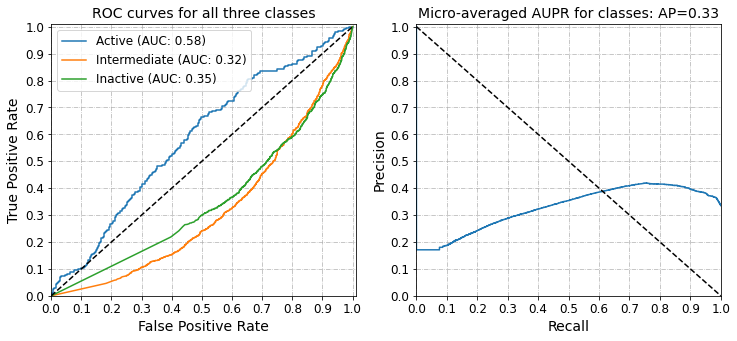

In [46]:
# Plot ROC/PR curve
obj.plotROC_PR(fpr, tpr, roc_auc, precision, recall, average_precision, validation=True, save=False)

In [ ]:
collections.Counter(a)